#  Glass Classification Report

## Introduction

The classification of glass types can be incredibly important during criminological investigations. At the scene of a crime, glass can be used as evidence so it is important to correctly determine if two or more glass fragments originated from different sources. This can lead to identifying methods of escape, murder weapons, and other pieces of conclusive evidence.  

Our goal is to create a model that is successful in identifying glass samples obtained from a crime scene based on the weight percentages of 8 corresponding oxides. More specifically, we hope to answer the question: Given the weight percent of 8 glass oxides from a glass sample, which of the 6 glass types is it?  

The particular dataset we have chosen comes from the USA Forensic Science Service and classifies 6 types of glass based on their oxide content (see below for more details). The dataset also contains the refractive index of each glass observation.

Note that float-processing is a glass manufacturing process that creates a smooth, thick and uniform surface. In this dataset, there is no data for “vehicle_windows_non_float_processed” glass.

<b>More details on the glass identification dataset:</b>

<b>Glass Oxides (measured in weight percent)</b>
<ul>
<li>Na: Sodium</li>
<li>Mg: Magnesium</li>
<li>Al: Aluminum</li>
<li>Si: Silicon</li>
<li>K: Potassium</li>
<li>Ca: Calcium</li>
<li>Ba: Barium</li>
<li>Fe: Iron</li>
</ul>
<b>Glass Types</b>
<ul>
<li>building_windows_float_processed</li>
<li>building_windows_non_float_processed</li>
<li>vehicle_windows_float_processed</li>
<li>vehicle_windows_non_float_processed (**none in this dataset**)</li>
<li>containers</li>
<li>tableware</li>
<li>headlamps</li>
</ul>

## Methods & Results

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("themis")
library(themis)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

#### Load data from the original source on the web 

In [2]:
dataset_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data"
col_names <- c("id", "RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "glass_type")
glass_data_raw <- read.table(dataset_url, sep =",", header = FALSE, col.names = col_names) |>
    mutate(glass_type = as_factor(glass_type))

glass_type_names <- c("building_windows_float_processed", "building_windows_non_float_processed", "vehicle_windows_float_processed", "containers", "tableware", "headlamps")
glass_data_processed <- glass_data_raw |> select(-RI)
levels(glass_data_processed$glass_type) <- glass_type_names

glass_type_counts <- glass_data_processed |>
    group_by(glass_type) |>
    summarize(count = n())


### ***note: all tables and figure should have a figure/table number and a legend

#### Wrangle and clean the data from its original (downloaded) format to the format necessary for the planned analysis

#### Perform a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 

#### Create a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis

#### Perform the data analysis

! Fold1: internal:
  No observations were detected in `truth` for level(s): 'vehicle_window...
  Computation will proceed by ignoring those levels.

! Fold2: internal:
  No observations were detected in `truth` for level(s): 'tableware'
  Computation will proceed by ignoring those levels.

! Fold3: internal:
  No observations were detected in `truth` for level(s): 'tableware'
  Computation will proceed by ignoring those levels.

! Fold4: internal:
  No observations were detected in `truth` for level(s): 'containers'
  Computation will proceed by ignoring those levels.

! Fold5: internal:
  No observations were detected in `truth` for level(s): 'tableware'
  Computation will proceed by ignoring those levels.



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.6116912,5,0.013255657,Preprocessor1_Model01
2,accuracy,multiclass,0.6116912,5,0.013255657,Preprocessor1_Model02
3,accuracy,multiclass,0.5465546,5,0.039607031,Preprocessor1_Model03
4,accuracy,multiclass,0.5292437,5,0.043165312,Preprocessor1_Model04
5,accuracy,multiclass,0.5121324,5,0.044374086,Preprocessor1_Model05
6,accuracy,multiclass,0.5117647,5,0.040244995,Preprocessor1_Model06
7,accuracy,multiclass,0.5413761,5,0.026880416,Preprocessor1_Model07
8,accuracy,multiclass,0.5351261,5,0.018864376,Preprocessor1_Model08
9,accuracy,multiclass,0.5354937,5,0.020660034,Preprocessor1_Model09


[1] 1

Model,Accuracy
<chr>,<dbl>
KNN,0.6116912
Most Common,0.3636364


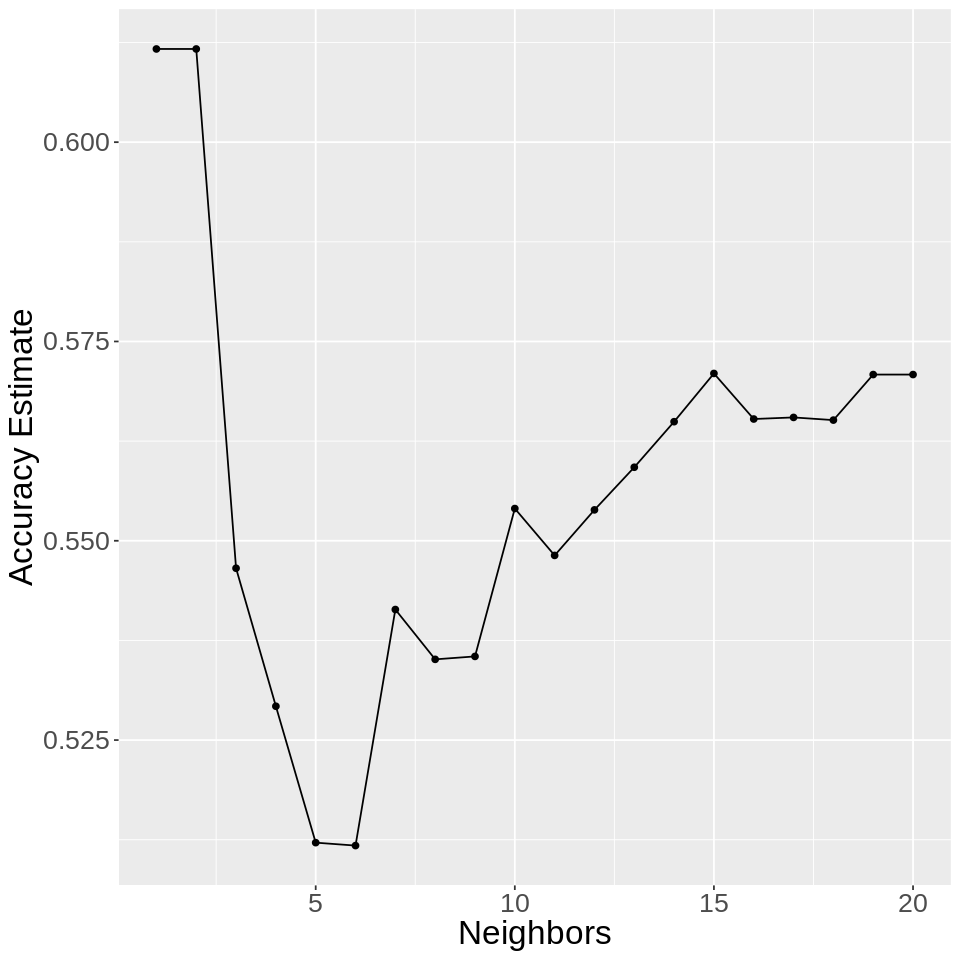

In [26]:
set.seed(9999) #TODO: Added this because of very different plots per run

options(repr.plot.width=8, repr.plot.height=8)

# wrange data furthur to remove id
glass_data <- glass_data_processed |> select(-id)

# split dataset into training and testing data
# TODO: check if appropriate proportion?
glass_split <- initial_split(glass_data, prop = 0.8, strata=glass_type)
glass_train <- training(glass_split)
glass_test <- testing(glass_split)

# Cross validation and tuning to find best k
glass_spec <- nearest_neighbor(weight_func="rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# TODO: not exactly sure if i should upsample here to balance data, maybe ask TA?
glass_recipe <- recipe(glass_type ~ ., data = glass_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(glass_type)

# 5-fold cross validation
vfold <- vfold_cv(glass_train, v=5, strata=glass_type)

# neighbors to try
# TODO: what should we try here?
vals <- tibble(neighbors = seq(from=1, to = 20))

knn_results <- workflow() |>
    add_recipe(glass_recipe) |>
    add_model(glass_spec) |>
    tune_grid(resamples = vfold, grid = vals)|>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric =="accuracy")

accuracies

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 20))
accuracy_vs_k
# TODO: might be a good idea to do forward selection to choose a subset of predictors https://datasciencebook.ca/classification2.html#fig:06-fwdsel-3
#       but this is probably overkill for this project

# we might also want to compare our results to the model that always chooses the most common class COMMENT IF THE FOLLOWING DOESN'T MAKES SENSE
# Get the number of neighbors that gave the highest accuracy
best_neighbors <- accuracies$neighbors[which.max(accuracies$mean)]
# Get the accuracy of the KNN model with the best number of neighbors
knn_accuracy <- accuracies$mean[which.max(accuracies$mean)]

# Implementing the Most Common Class model
# Create a table of class counts in the training data
class_counts <- table(glass_train$glass_type)
# Get the class with the highest count
most_common_class <- names(which.max(class_counts))
# Create a vector of predictions for the test data using the most common class
most_common_predictions <- rep(most_common_class, nrow(glass_test))
# Calculate the accuracy of the baseline model
most_common_accuracy <- mean(most_common_predictions == glass_test$glass_type)

accuracy_tbl <- tibble(Model = c("KNN", "Most Common"),
                       Accuracy = c(knn_accuracy, most_common_accuracy)) #!!!
accuracy_tbl


In [31]:
set.seed(9999)
#Using algorithm on test data with k = 1 and creating a confusion matrix
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_neighbors) |> 
            set_engine("kknn") |> 
            set_mode("classification") 

knn_fit <- workflow() |> 
            add_recipe(glass_recipe) |> 
            add_model(knn_spec) |> 
            fit(data = glass_train) 

glass_test_predictions <- predict(knn_fit, glass_test) |> 
                            bind_cols(glass_test) #add predictions into dataset 

glass_test_predictions |> 
    metrics(truth = glass_type, estimate = .pred_class) |> 
    filter(.metric == "accuracy") 

#Confusion matrix <- not sure how useful this is
confusion <- glass_test_predictions |> 
             conf_mat(truth = glass_type, estimate = .pred_class) 
confusion
#We can directly see that glass types with fewer observations have more unpredictable 
#accuracies, but generally have lower accuracies


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.6590909


                                      Truth
Prediction                             building_windows_float_processed
  building_windows_float_processed                                    9
  building_windows_non_float_processed                                1
  vehicle_windows_float_processed                                     4
  containers                                                          0
  tableware                                                           0
  headlamps                                                           0
                                      Truth
Prediction                             building_windows_non_float_processed
  building_windows_float_processed                                        2
  building_windows_non_float_processed                                    9
  vehicle_windows_float_processed                                         2
  containers                                                              2
  tableware                 

#### Create a visualization of the analysis 

`summarise()` has grouped output by 'glass_type'. You can override using the
`.groups` argument.


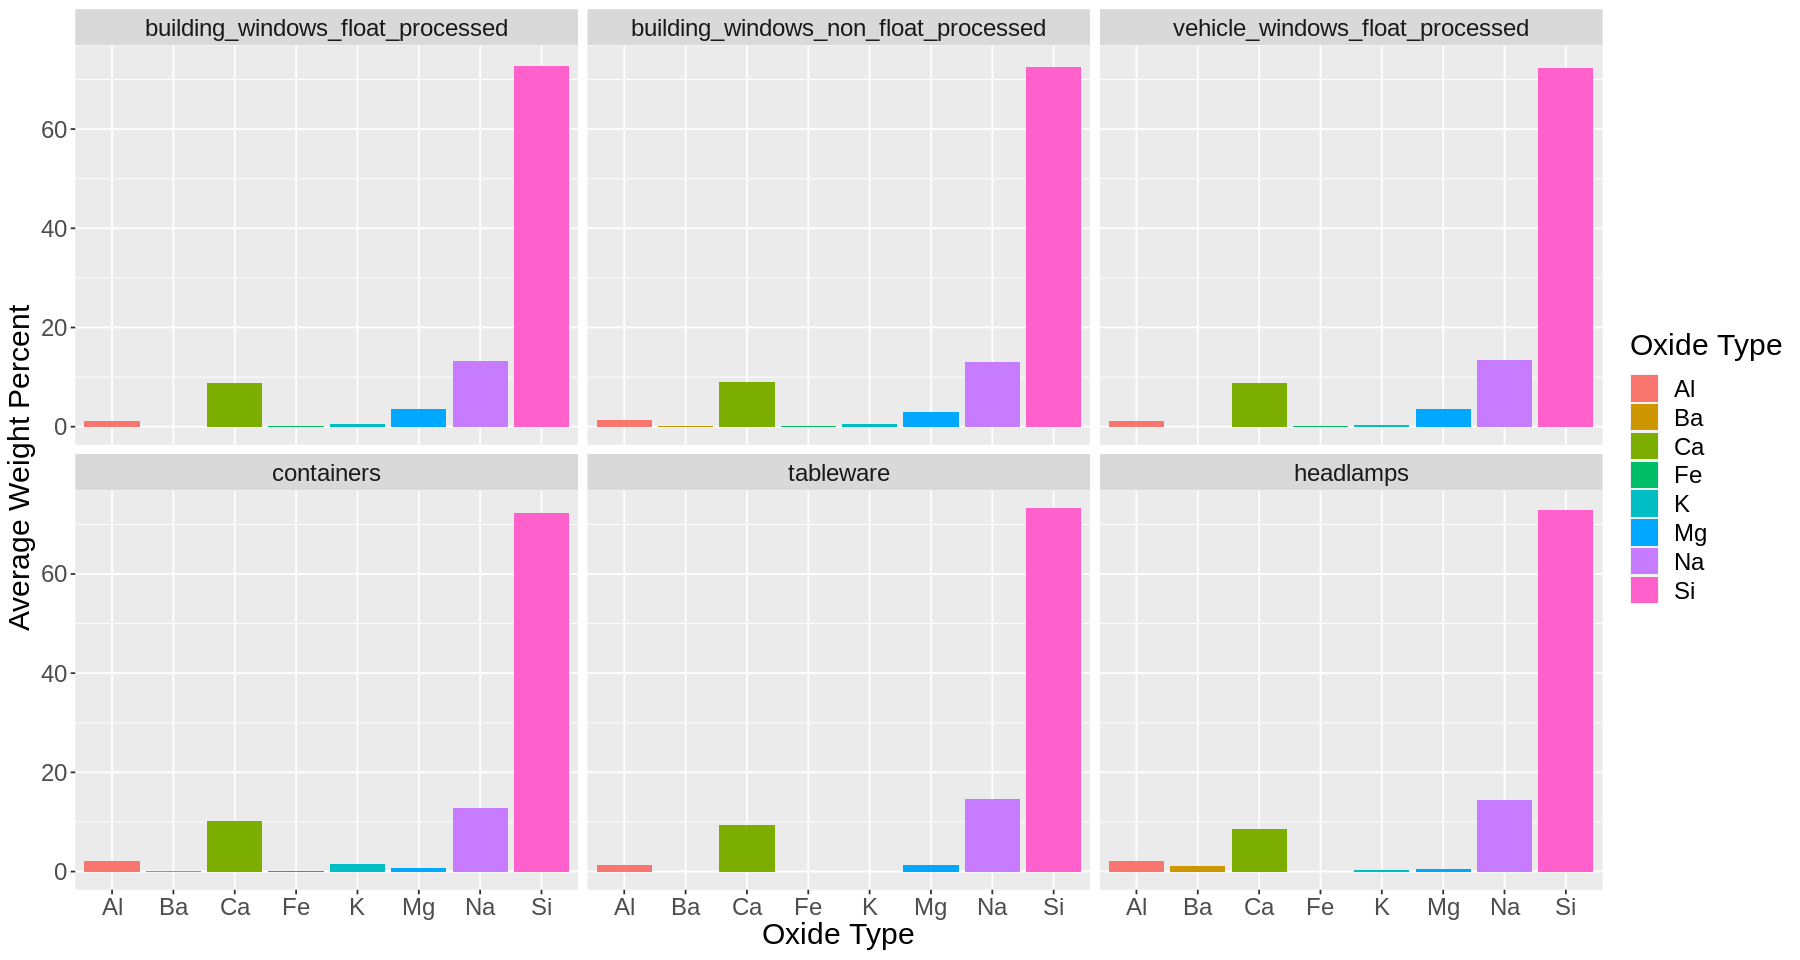

In [4]:
options(repr.plot.width=15, repr.plot.height=8)

glass_visual_data <- glass_data_processed |>
    pivot_longer(cols = Na:Fe, names_to = "oxide_type", values_to = "weight_percent") |>
    group_by(glass_type, oxide_type) |>
    summarise(mean_weight_percent = mean(weight_percent)) |>
    ungroup()

glass_visual_plot <- glass_visual_data |>
    ggplot(aes(x = oxide_type, y = mean_weight_percent, fill = oxide_type)) +
    geom_bar(stat = "identity", position = "dodge") +
    labs(x = "Oxide Type", y = "Average Weight Percent", fill = "Oxide Type") +
    facet_wrap(~glass_type, nrow = 2) +
    theme(text = element_text(size = 18))
glass_visual_plot